# Meander Maker

If you haven't ever used the `googlemaps` python package, there are a few small setup steps to take first. You'll need to install it by running the next cell. Additionally, we will use `gmplot` to render the outputs and `polyline` to decode [Google's "Polyline"](https://developers.google.com/maps/documentation/utilities/polylineutility) hash. Finally, generate an API key to interface with Google's services. (There is a free tier, but if you use it a lot, they will start charging you for access.)

In [ ]:
!pip install googlemaps
!pip install gmplot
!pip install polyline
!pip install haversine

In [ ]:
!conda install -c conda-forge hdbscan

As mentioned above, if you would like to tinker around with the code, you'll need your own API key for Google Maps. You can register one from this address: [https://developers.google.com/places/web-service/get-api-key](https://developers.google.com/places/web-service/get-api-key). Once you have one, create a file in the directory containing this notebook called `.secret.key` and simply paste in your newly generated API key, no quotes or line breaks or anything. Save the file, exit, and you should be good to go.

In [1]:
import goplaces as gp

%load_ext autoreload
%autoreload 2

/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



Let's decide which topic to explore:

In [4]:
loc, topic = gp.populate_inputs()

Where would you like to start? Seattle
What theme would you like to explore today? bar


/Users/dakaspar/flatiron/meander_maker/goplaces.py:276: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/dakaspar/flatiron/meander_maker/goplaces.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/dakaspar/flatiron/meander_maker/goplaces.py:276: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



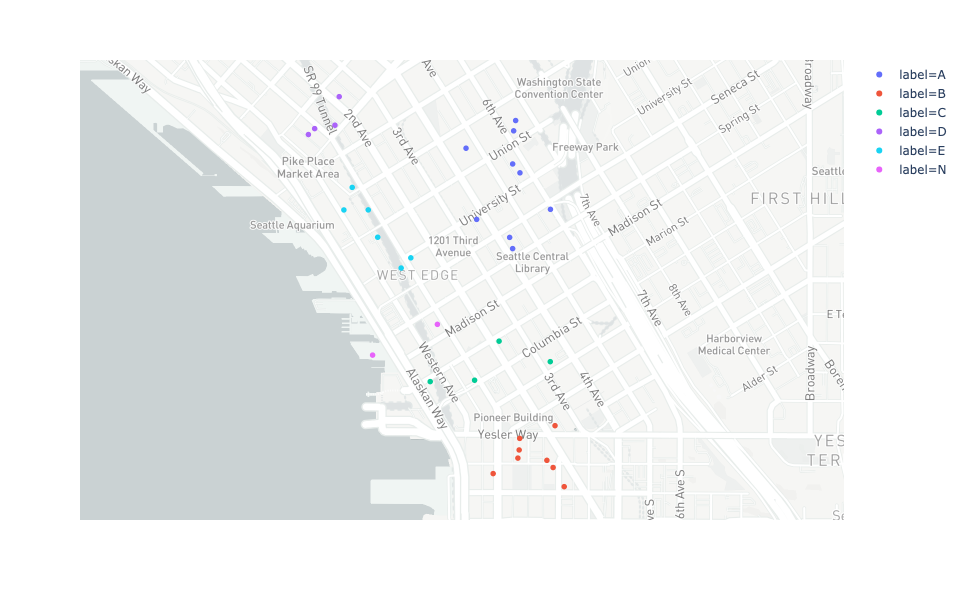

In [17]:
df = gp.build_df(loc, topic)
best_cluster = gp.choose_cluster(df, loc, verbose=False)
gp.mapbox(best_cluster)

In [18]:
wlk = gp.meander(best_cluster, loc, mode='walking', verbose=True)
gp.html_builder(loc, wlk, tab=True)

/Users/dakaspar/flatiron/meander_maker/goplaces.py:276: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



+93 m --and-- +1.2 min
+191 m --and-- +2.92 min
+302 m --and-- +3.68 min
+25 m --and-- +0.35 min
+138 m --and-- +2.18 min
+106 m --and-- +1.48 min
+208 m --and-- +2.77 min
+274 m --and-- +3.43 min
total dist: 1337 m 
est time: 18.0 min


.  
.  
---------TESTING---------TESTING---------TESTING---------TESTING---------TESTING---------  
.  
.  

In [ ]:
def cluster(df, min_size=4, allow_single_cluster=True):
    """
    Use HDBSCAN --
    (Hierarchical Density-Based Spatial Clustering of Applications with Noise)
    to find the best clusters for the meander.
    """
    clusterer = HDBSCAN(
        min_cluster_size=min_size, 
        min_samples=3, 
        metric='haversine', 
        allow_single_cluster=allow_single_cluster
    )
    clusterer.fit(df[['lat', 'lng']])
    df['label'] = ['ABCDEFGHIJKLMN'[i] for i in clusterer.labels_]
    #output = df.loc[df['label'] >= 'A']
    return df.sort_values('label').reset_index(drop=True)

In [ ]:
def choose_cluster(df, loc, mode='walking', verbose=False):
    """
    TODO: SettingWithCopyWarning still shows up
          Scale the "internal walking dist" to depend on mode of transport
    ---------------------
    Accepts a df from build_df() and chooses the optimal cluster to meander.
    loc is the starting location of the search, which should be a dictionary of
    the form: {'lat': 47.606269, 'lng': -122.334747}
    """
    scores = {}
    poss_clusters = {}
    for i in df['label'].unique():
        cluster = df.loc[df['label'] == i, :]
        cluster['dist_to_loc'] = df.apply(
            lambda row: haver_wrapper(row, loc), axis=1)
        poss_clusters[i] = cluster
        scores[i] = round(cluster_metric(cluster, loc), 4)
    
    key_of_best = max(scores, key=lambda k: scores[k])
    output = poss_clusters[key_of_best]
    
    if verbose:
        display(scores)
        for cluster in poss_clusters.values():
            display(cluster)
    if len(output) > 10:
        display(output)
        forced_split = cluster(output, min_size=4, allow_single_cluster=False)
        return choose_cluster(forced_split, loc, mode, verbose=False)
    return output